In [2]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_functions import *
import matplotlib.pyplot as plt
from biotuner.biotuner2d import*
from biotuner.biotuner_object import *
import mne
from scipy import signal
import warnings
import neurokit2 as nk
import pandas as pd
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

pygame 2.0.2 (SDL 2.0.16, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Convergent validity of harmonicity metrics

First we will load EEG data. 

In [3]:
path = 'C:/Users/Dell/GitHub/biotuner/examples/data_examples/'
EEG_data = np.load(path+'parei_data_1000ts.npy')
EEG_sf = 1000
EEG_data.shape

(500, 9501)

We will graph a **correlation matrix using all the harmonicity metrics**. We need to specify which *peaks_function* is being used. We will later compare *peaks_function* with each other. First, let's start with *fixed* bands using **5 bands** spanning **1 octave each**. We will use 250 segments of 3 seconds with a precision of 0.5Hz.

[Text(0, 0.5, 'peaks'),
 Text(0, 1.5, 'cons'),
 Text(0, 2.5, 'harmsim'),
 Text(0, 3.5, 'tenney'),
 Text(0, 4.5, 'spectro_chords'),
 Text(0, 5.5, 'spectro_chords_cons'),
 Text(0, 6.5, 'spectro_chords_cons+'),
 Text(0, 7.5, 'diss_n_steps'),
 Text(0, 8.5, 'dissonance'),
 Text(0, 9.5, 'matrix_cons'),
 Text(0, 10.5, 'matrix_harm_sim'),
 Text(0, 11.5, 'sum_q_for_all_intervals'),
 Text(0, 12.5, 'sum_distinct_intervals'),
 Text(0, 13.5, 'sum_p_q')]

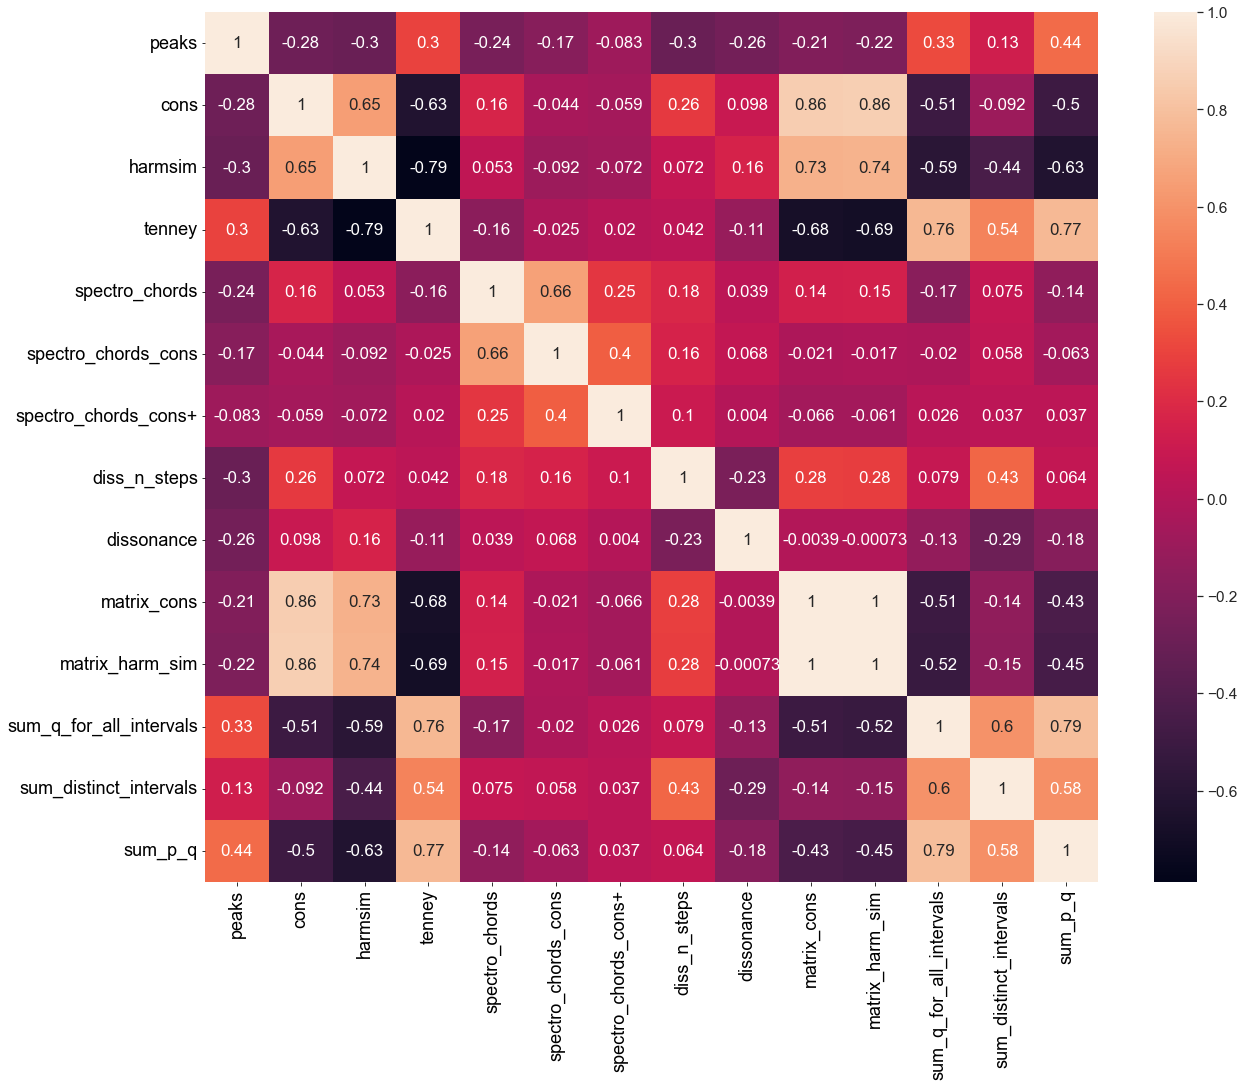

In [3]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
df_metrics = compare_metrics(EEG_data[0:250,2000:5000], 1000, peaks_function='fixed', precision=0.5,
                            min_notes=3, cons_limit=0.1, chords_multiple_metrics=True, add_cons=0.3, add_notes=2, 
                            FREQ_BANDS = FREQ_BANDS)

df_corr = df_metrics.corr()
fig, ax = plt.subplots(figsize=(20,16))
sbn.set(font_scale=1.4)
res = sbn.heatmap(df_corr, annot=True, cmap='rocket')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)

Let's do the same using Ensemble Empirical Mode Decomposition method (EEMD). 

[Text(0, 0.5, 'peaks'),
 Text(0, 1.5, 'cons'),
 Text(0, 2.5, 'harmsim'),
 Text(0, 3.5, 'tenney'),
 Text(0, 4.5, 'spectro_chords'),
 Text(0, 5.5, 'spectro_chords_cons'),
 Text(0, 6.5, 'spectro_chords_cons+'),
 Text(0, 7.5, 'diss_n_steps'),
 Text(0, 8.5, 'dissonance'),
 Text(0, 9.5, 'matrix_cons'),
 Text(0, 10.5, 'matrix_harm_sim'),
 Text(0, 11.5, 'sum_q_for_all_intervals'),
 Text(0, 12.5, 'sum_distinct_intervals'),
 Text(0, 13.5, 'sum_p_q')]

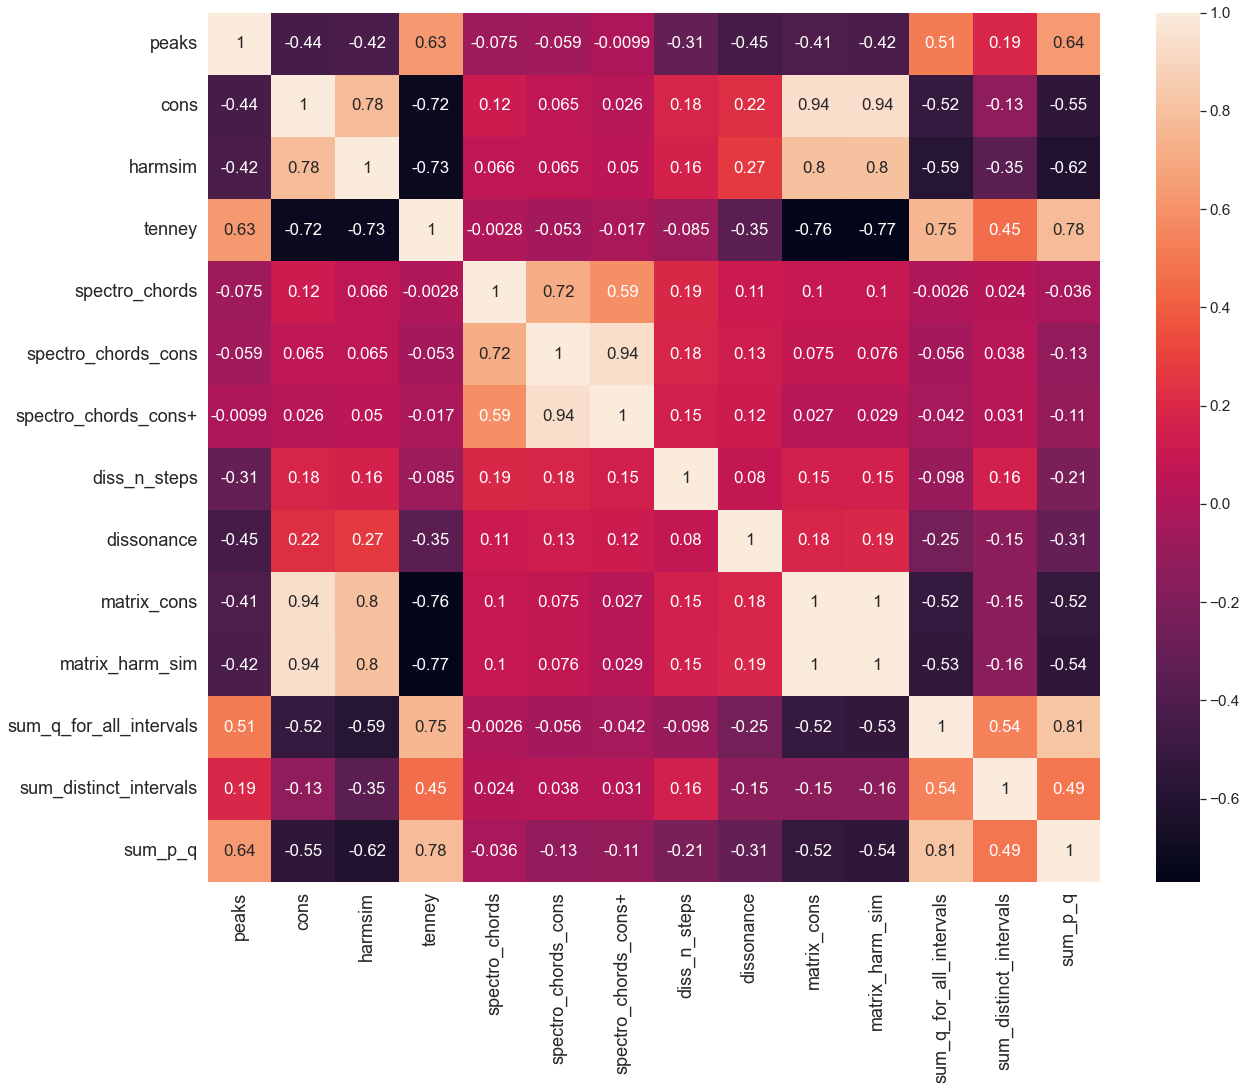

In [4]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
df_metrics = compare_metrics(EEG_data[0:250,2000:5000], 1000, peaks_function='EEMD', precision=0.5,
                            min_notes=3, cons_limit=0.1, chords_multiple_metrics=True, add_cons=0.3, add_notes=2, 
                            FREQ_BANDS = FREQ_BANDS)
df_corr = df_metrics.corr()
fig, ax = plt.subplots(figsize=(20,16))
sbn.set(font_scale=1.4)
res = sbn.heatmap(df_corr, annot=True, cmap='rocket')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)

Since this method uses dyadic filter bank (octave filter bank) to decompose the signal into Intrinsic Mode Functions, we expect that harmonicity metrics might have slightly higher scores as compared to other methods. To test this, we will **plot the average of all metrics for different peak extraction methods**.

The *compare_corr_metrics_peaks* function takes an array of *trials * time_series* and return a dataframe in the shape *peaks_functions * harmonicity_metrics* of the correlation with the averaged peaks frequency (*df_peaks_tot*). 

It also returns a list of dataframes (one per peaks function) in the shape *harmonicity metrics * trials*. (*df_metrics_all*)

In [61]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['HH1D_max', 'harmonic_peaks', 'fixed', 'adapt', 'EMD', 'EEMD', 'FOOOF']
df_peaks_EEG, df_metrics_EEG = compare_corr_metrics_peaks(EEG_data[0:250, 2000:5000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=3, cons_limit=0.1, chords_multiple_metrics=True)

harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF


Then, we will plot the **average of all metrics correlation** to see if it varies **across peak extraction methods**

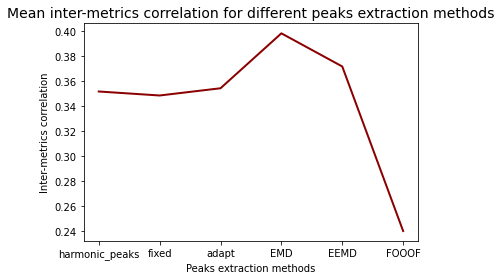

In [86]:
df_metrics_corr_avg = pd.DataFrame()
for method in range(len(df_metrics_all)):
    df_metrics_corr_avg[peaks_functions[method]] = [np.average(abs(df_metrics_all[method].iloc[:, 1:].corr()))]


plt.plot(df_metrics_corr_avg.loc[0], color='darkred', linewidth=2)
plt.title('Mean inter-metrics correlation for different peaks extraction methods', fontsize=14)
plt.xlabel('Peaks extraction methods')
plt.ylabel('Inter-metrics correlation')
plt.show()
#df_metrics_corr_avg

We will do the same but with a peak precision of **0.1Hz** instead of 0.5Hz to see if the results are constant

In [95]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['harmonic_peaks', 'fixed', 'adapt', 'EMD', 'EEMD', 'FOOOF']
df_peaks_EEG2, df_metrics_EEG2 = compare_corr_metrics_peaks(EEG_data[0:250, 4000:9000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.1, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=3, cons_limit=0.1, chords_multiple_metrics=True)

harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF


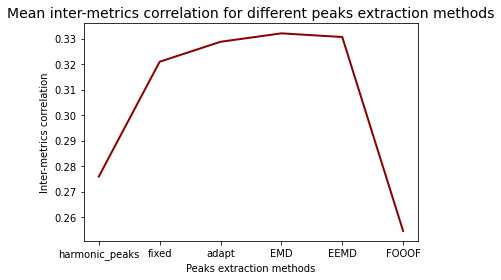

In [96]:
df_metrics_corr_avg = pd.DataFrame()
for method in range(len(df_metrics_EEG2)):
    df_metrics_corr_avg[peaks_functions[method]] = [np.average(abs(df_metrics_EEG2[method].iloc[:, 1:].corr()))]


plt.plot(df_metrics_corr_avg.loc[0], color='darkred', linewidth=2)
plt.title('Mean inter-metrics correlation for different peaks extraction methods', fontsize=14)
plt.xlabel('Peaks extraction methods')
plt.ylabel('Inter-metrics correlation')
plt.show()
#df_metrics_corr_avg

## How do harmonicity metrics are affected by averaged frequency values ?

Since the *Biotuner* computes hamonicity metrics on frequency peaks, we want to observe how these metrics correlate with the averaged frequencyof their input. In other words, **are lower frequencies more consonant than higher frequencies ?** 

To answer this question, we will look at how the correlation between mean frequency and harmonicity metrics varies across peak extraction methods.

In [273]:
df_sorted_EEG = df_peaks_EEG.sort_values(by = ['EEMD', 'EMD', 'fixed', 'adapt', 'FOOOF', 'harmonic_peaks'])
df_sorted_EEG = df_sorted_EEG #we remove the correlation of peaks with peaks (always equals 1)

<function matplotlib.pyplot.show(close=None, block=None)>

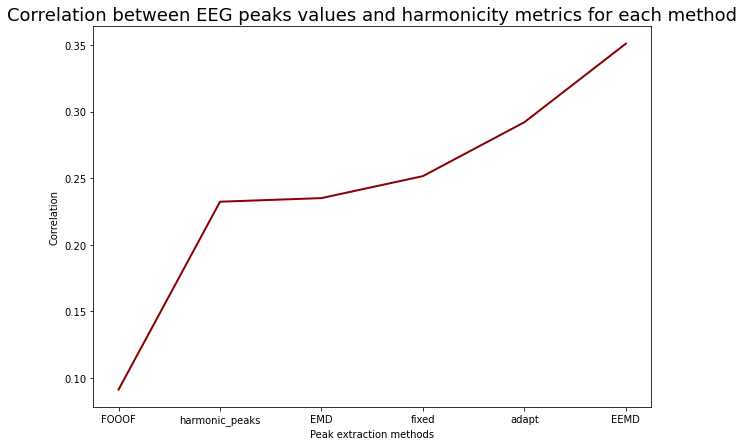

In [89]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG.mean(axis=0).sort_values(), color = 'darkred', linewidth=2)
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics for each method', fontsize=18)
plt.xlabel('Peak extraction methods')
plt.ylabel('Correlation')
plt.show

Here we explore how harmonicity metrics correlate with frequency peaks in average of all peak extraction methods

<function matplotlib.pyplot.show(close=None, block=None)>

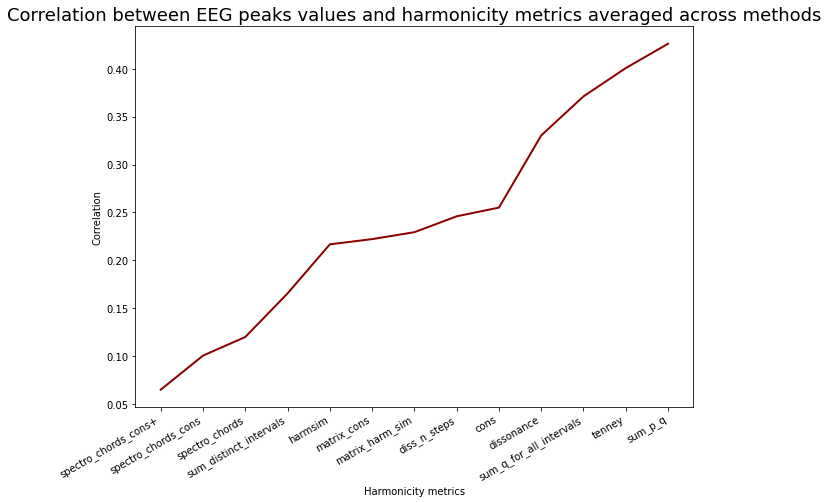

In [90]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG.mean(axis=1).sort_values(), color = 'darkred', linewidth=2)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics averaged across methods', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

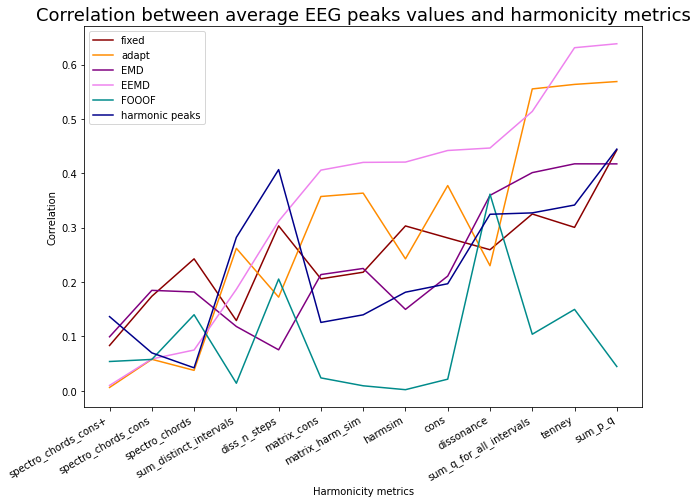

In [93]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG['fixed'], color='darkred', label="fixed")
plt.plot(df_sorted_EEG['adapt'], color='darkorange', label="adapt")
plt.plot(df_sorted_EEG['EMD'], color='purple', label="EMD")
plt.plot(df_sorted_EEG['EEMD'], color='violet', label="EEMD")
plt.plot(df_sorted_EEG['FOOOF'], color='darkcyan', label="FOOOF")
plt.plot(df_sorted_EEG['harmonic_peaks'], color='darkblue', label="harmonic peaks")
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between average EEG peaks values and harmonicity metrics', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.show

### We will do the same analyses with peaks precision at 0.1Hz

In [97]:
df_sorted_EEG2 = df_peaks_EEG2.sort_values(by = ['EEMD', 'EMD', 'fixed', 'adapt', 'FOOOF', 'harmonic_peaks'])
df_sorted_EEG2 = df_sorted_EEG2.iloc[:-1] #we remove the correlation of peaks with peaks (always equals 1)

,harmonic_peaks,fixed,adapt,EMD,EEMD,FOOOF
spectro_chords_cons,0.281161,0.193293,0.002376,0.077057,0.030449,0.252348
spectro_chords_cons+,0.052800,0.059765,0.099957,0.118170,0.045577,0.192623
sum_distinct_intervals,0.033458,0.096621,0.139295,0.126917,0.060859,0.515667
spectro_chords,0.328876,0.203265,0.013070,0.021922,0.068899,0.326392
diss_n_steps,0.217241,0.319033,0.092513,0.136091,0.180111,0.195716
matrix_cons,0.083710,0.097361,0.196131,0.228430,0.190118,0.037248
harmsim,0.037962,0.000147,0.186842,0.203409,0.193363,0.037097
cons,0.027475,0.066709,0.309177,0.281221,0.196541,0.064264
matrix_harm_sim,0.068448,0.107797,0.229488,0.243612,0.197023,0.051979
dissonance,0.523427,0.333035,0.571889,0.379238,0.358474,0.033127


<function matplotlib.pyplot.show(close=None, block=None)>

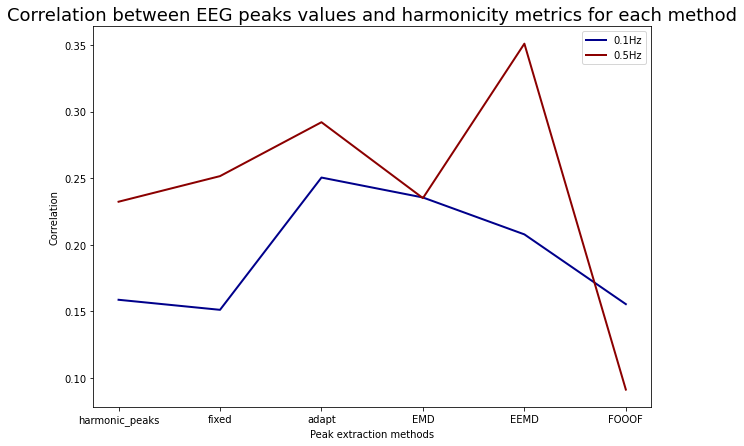

In [123]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG2.mean(axis=0), color = 'darkblue', linewidth=2, label='0.1Hz')
plt.plot(df_sorted_EEG.mean(axis=0), color = 'darkred', linewidth=2, label='0.5Hz')
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics for each method', fontsize=18)
plt.legend()
plt.xlabel('Peak extraction methods')
plt.ylabel('Correlation')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

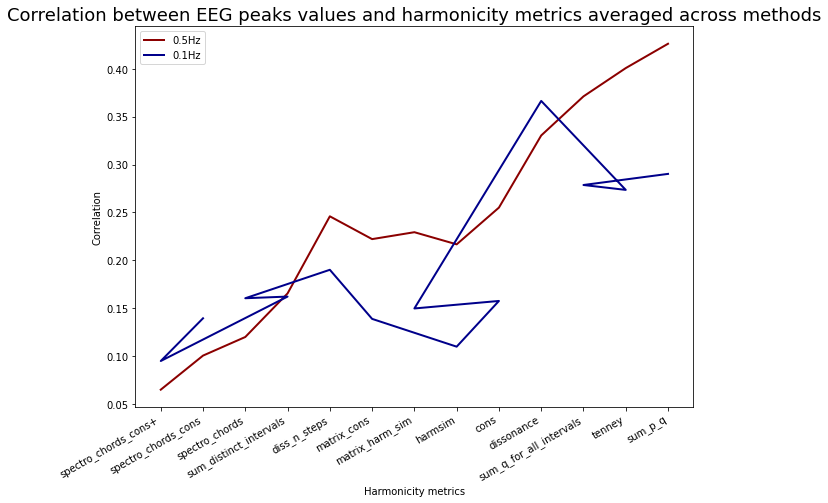

In [124]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG.mean(axis=1), color = 'darkred', linewidth=2, label='0.5Hz')
plt.scatter(df_sorted_EEG2.mean(axis=1), color = 'darkblue', linewidth=2, label='0.1Hz')

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics averaged across methods', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

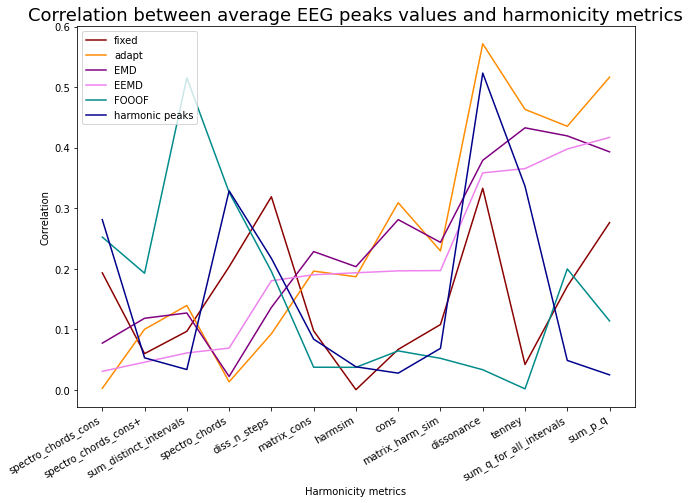

In [100]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG2['fixed'], color='darkred', label="fixed")
plt.plot(df_sorted_EEG2['adapt'], color='darkorange', label="adapt")
plt.plot(df_sorted_EGG2['EMD'], color='purple', label="EMD")
plt.plot(df_sorted_EEG2['EEMD'], color='violet', label="EEMD")
plt.plot(df_sorted_EEG2['FOOOF'], color='darkcyan', label="FOOOF")
plt.plot(df_sorted_EEG2['harmonic_peaks'], color='darkblue', label="harmonic peaks")
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between average EEG peaks values and harmonicity metrics', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.show

## Which harmonicity metrics best distinguish between EEG and ECG ?

In [400]:
#ECG
path = 'data_examples/ECG/'
data = mne.io.read_raw_edf(path + '/r01.edf', preload = True)
ECG_data = data.load_data()
ECG_data = ECG_data.get_data()
ECG_sf = 1000
ECG_data = slice_data(ECG_data[0:4], ECG_sf, window=5)
ECG_data.shape
EEG_data, ECG_data = equate_dimensions(EEG_data, ECG_data)


Extracting EDF parameters from C:\Users\Dell\GitHub\biotuner\examples\data_examples\ECG\r01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...


In [294]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['HH1D_max', 'harmonic_peaks', 'fixed', 'adapt', 'EMD', 'EEMD', 'FOOOF']
peaks_corr_ECG, ECG_metrics = compare_corr_metrics_peaks(ECG_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

peaks_corr_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

ECG_metrics = np.array(ECG_metrics)
EEG_metrics = np.array(EEG_metrics)

HH1D_max
harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF
HH1D_max
harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF


We will look at how the correlation between peak frequencies and harmonicity metrics differs between ECG and EEG

<function matplotlib.pyplot.show(close=None, block=None)>

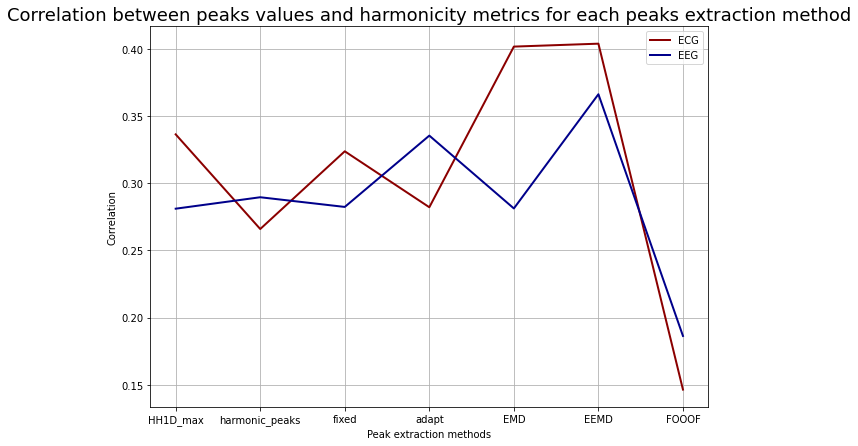

In [353]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(peaks_corr_ECG.mean(axis=0), color = 'darkred', linewidth=2, label="ECG")
plt.plot(peaks_corr_EEG.mean(axis=0), color = 'darkblue', linewidth=2, label='EEG')
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between peaks values and harmonicity metrics for each peaks extraction method', fontsize=18)
plt.xlabel('Peak extraction methods')
plt.legend()
plt.grid()
plt.ylabel('Correlation')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

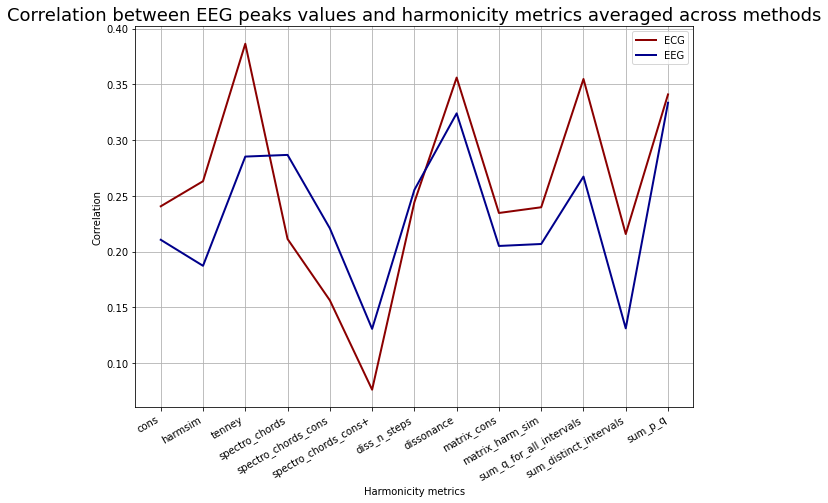

In [355]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(peaks_corr_ECG.mean(axis=1)[1:], color = 'darkred', linewidth=2, label='ECG')
plt.plot(peaks_corr_EEG.mean(axis=1)[1:], color = 'darkblue', linewidth=2, label='EEG')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics averaged across methods', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.grid()
plt.legend()
plt.show

### We will evaluate with t tests which harmonicity metrics and peaks extraction functions best distinguish between ECG and EEG signals

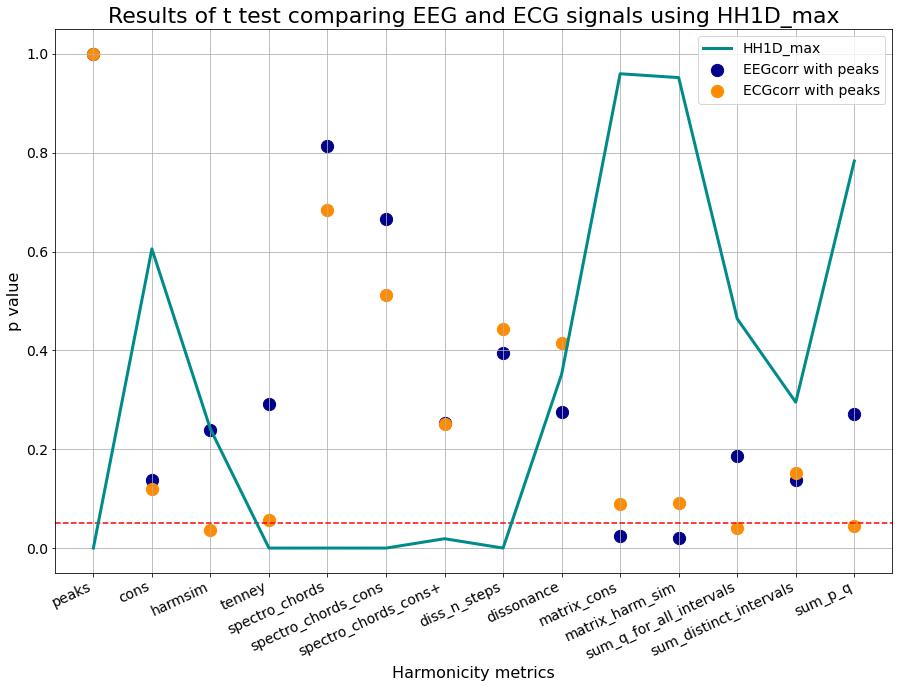

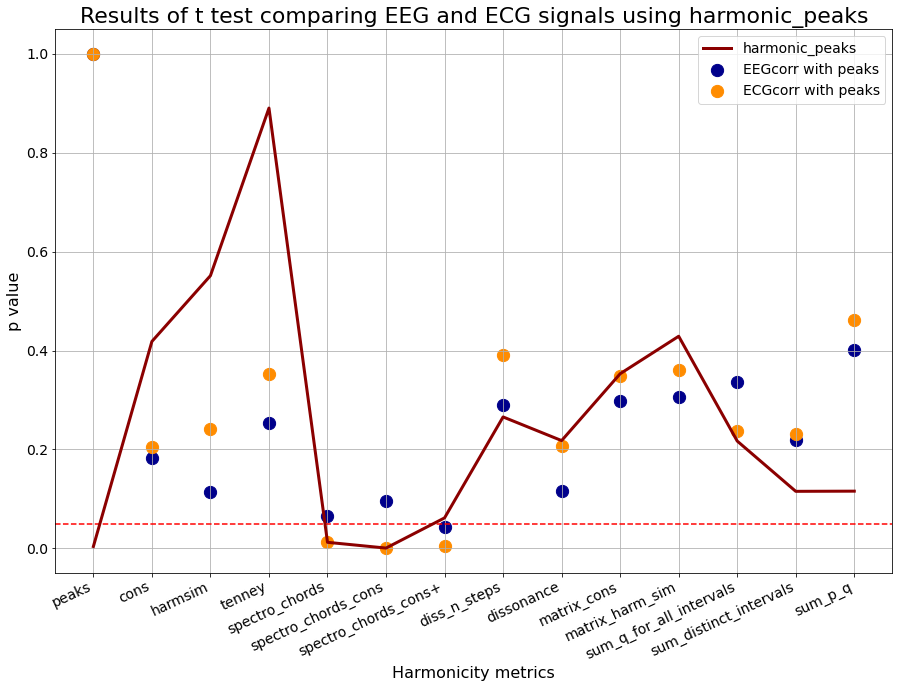

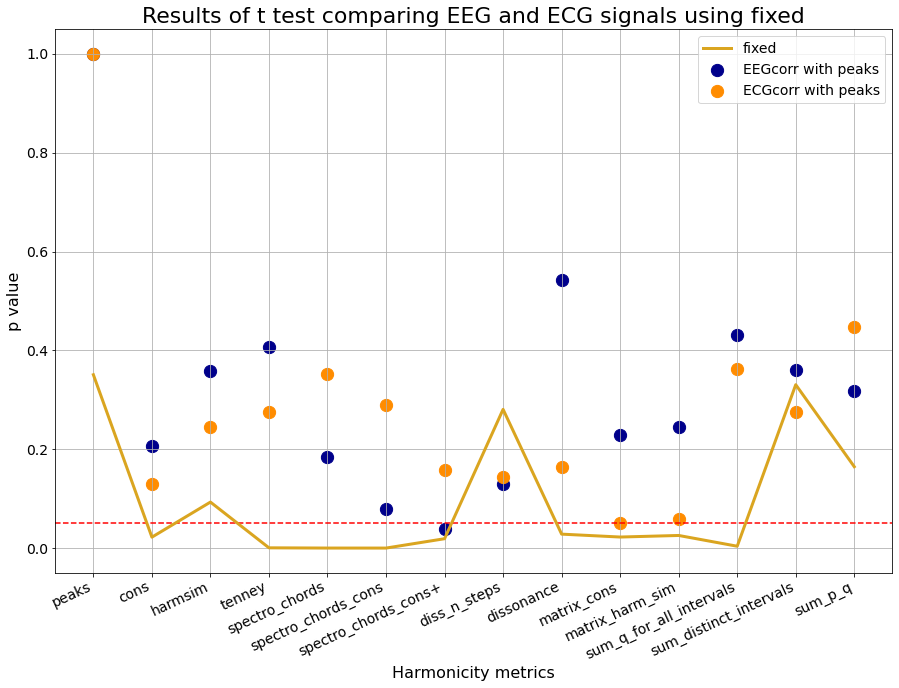

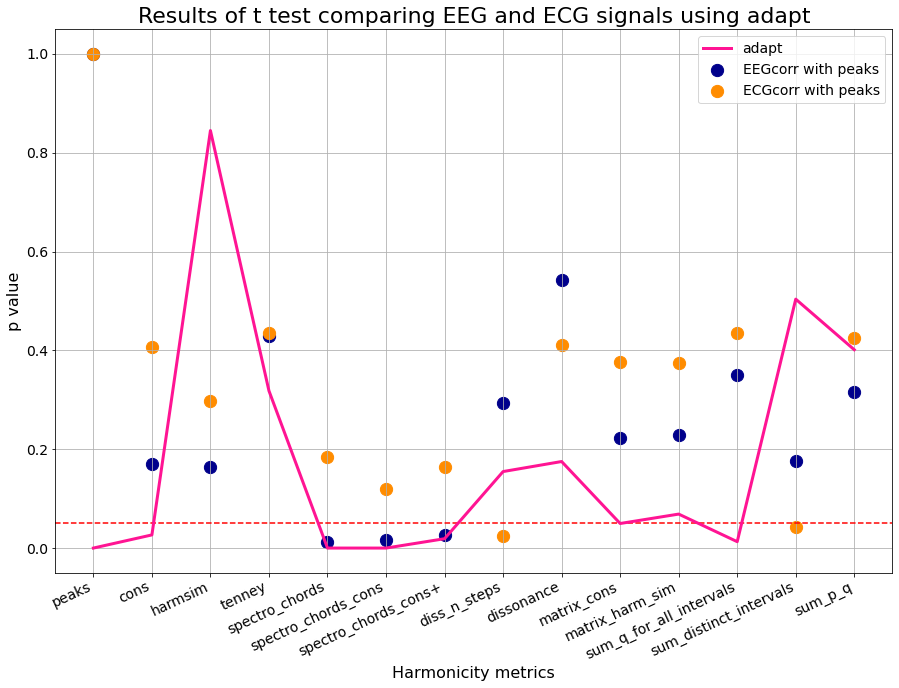

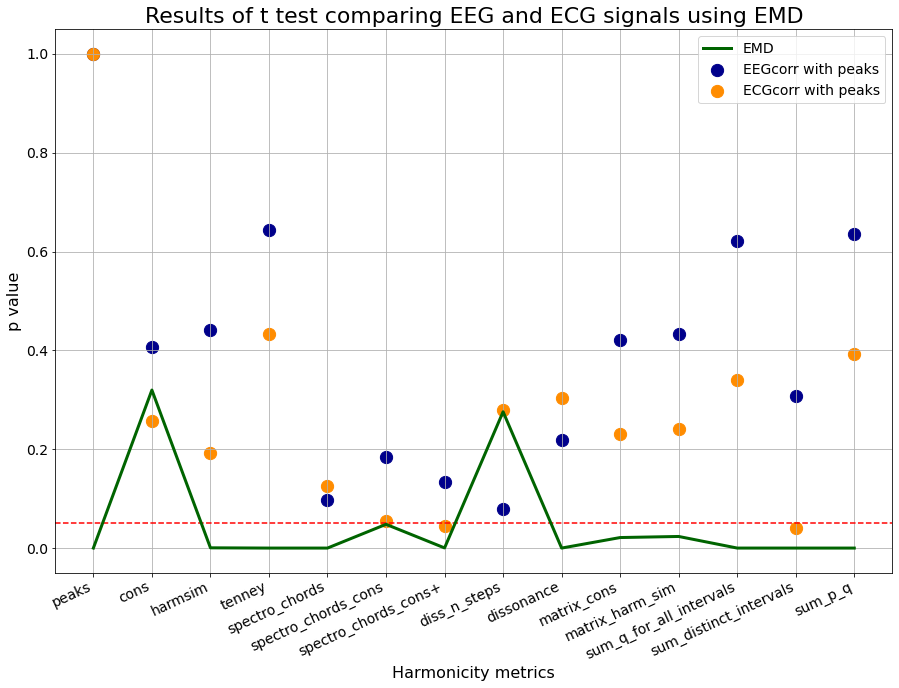

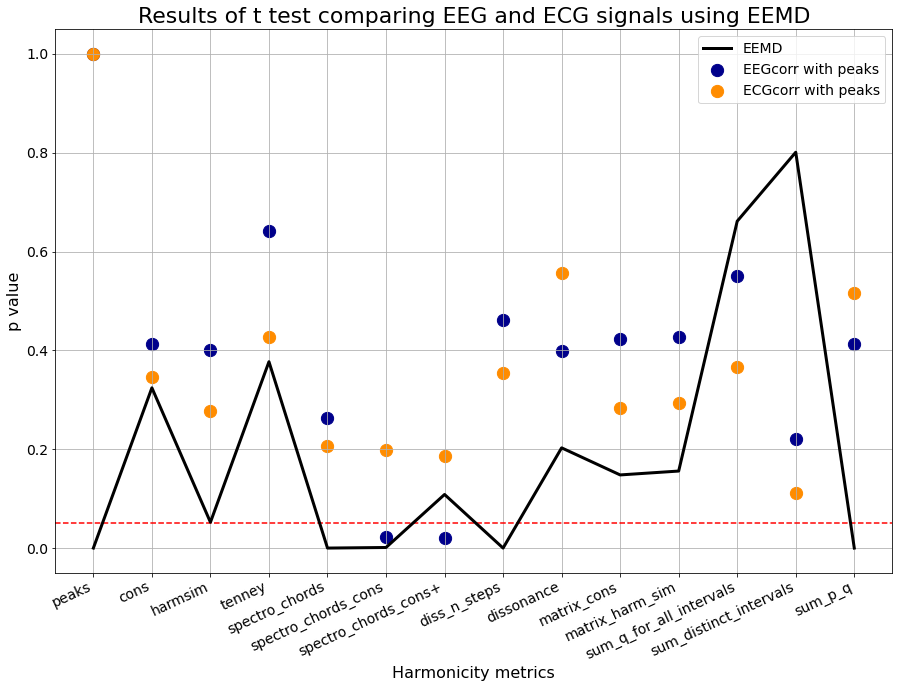

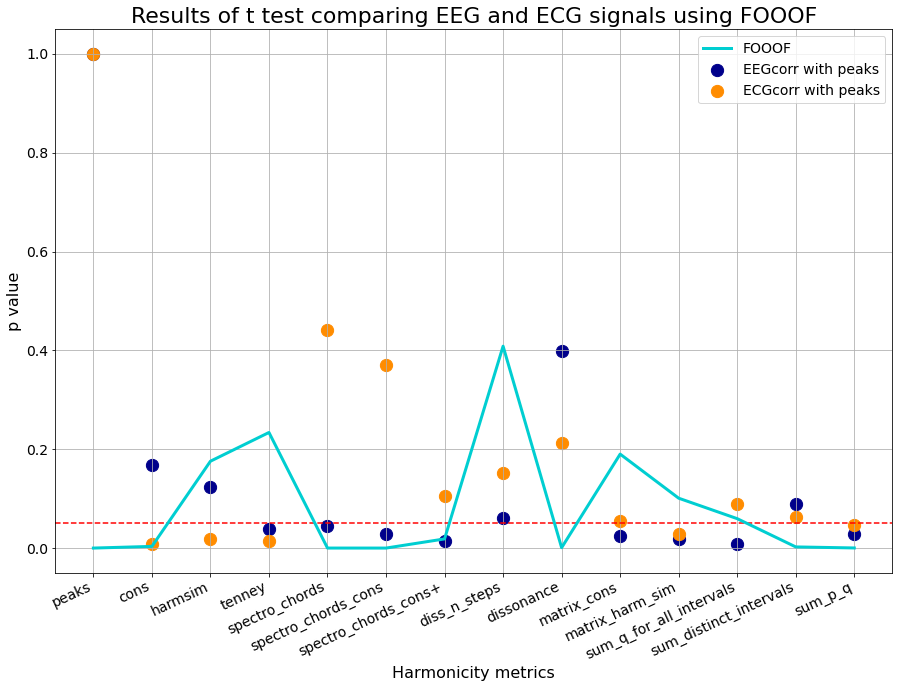

In [343]:
ttest_all = ttest_all_metrics(ECG_metrics, EEG_metrics, peaks_functions)
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['EEG', 'ECG'], 
                           peaks_corr1=peaks_corr_ECG, peaks_corr2=peaks_corr_EEG, color=color, save=True)

<function matplotlib.pyplot.show(close=None, block=None)>

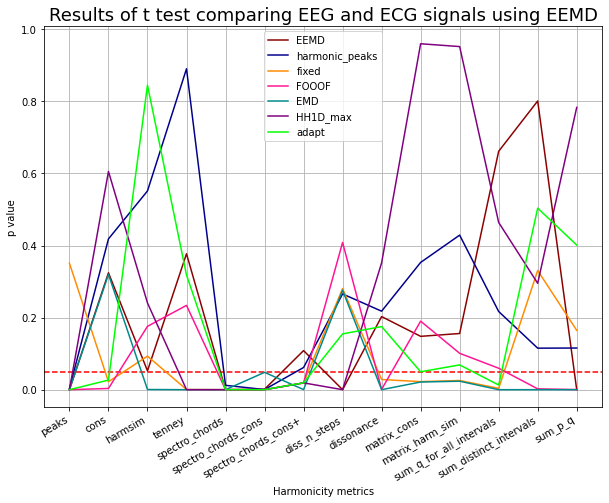

In [361]:
fig, ax = plt.subplots(figsize=(10,7))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Results of t test comparing EEG and ECG signals using EEMD', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('p value')
plt.axhline(y=0.05, color='r', linestyle='--')

plt.plot(ttest_all['EEMD'], color='darkred', label='EEMD')
plt.plot(ttest_all['harmonic_peaks'], color='darkblue', label='harmonic_peaks')
plt.plot(ttest_all['fixed'], color='darkorange', label='fixed')
plt.plot(ttest_all['FOOOF'], color='deeppink', label='FOOOF')
plt.plot(ttest_all['EMD'], color='darkcyan', label='EMD')
plt.plot(ttest_all['HH1D_max'], color='purple', label='HH1D_max')
plt.plot(ttest_all['adapt'], color='lime', label='adapt')
plt.grid()
plt.legend()
plt.show

<BarContainer object of 7 artists>

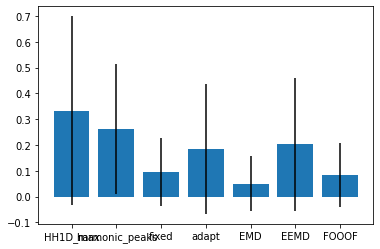

In [394]:
plt.bar(list(ttest_all.head()), ttest_all.mean(axis=0), yerr=ttest_all.std(axis=0))

## Which harmonicity metrics best distinguish between EEG and pink noise ?

In [404]:
path = 'C:/Users/Dell/GitHub/biotuner/examples/data_examples/'
EEG_data = np.load(path+'parei_data_1000ts.npy')
EEG_sf = 1000
EEG_data.shape

(500, 9501)

In [421]:
pink_data = surrogate_signal_matrices(EEG_data[0:250, 2000:7000], surr_type = 'pink', low_cut = 0.5, high_cut = 150, sf = 1000)

In [407]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['HH1D_max', 'harmonic_peaks', 'fixed', 'adapt', 'EMD', 'EEMD', 'FOOOF']
peaks_corr_pink, pink_metrics = compare_corr_metrics_peaks(pink_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

peaks_corr_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

pink_metrics = np.array(pink_metrics)
EEG_metrics = np.array(EEG_metrics)

HH1D_max
harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF
HH1D_max
harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF


In [409]:
np.save('peaks_corr_EEG_0.5.npy', peaks_corr_EEG)
np.save('peaks_corr_pink_0.5.npy', peaks_corr_pink)

np.save('EEG_metrics_0.5.npy', EEG_metrics)
np.save('pink_metrics_0.5.npy', pink_metrics)

0
1
2
3
4
5
6


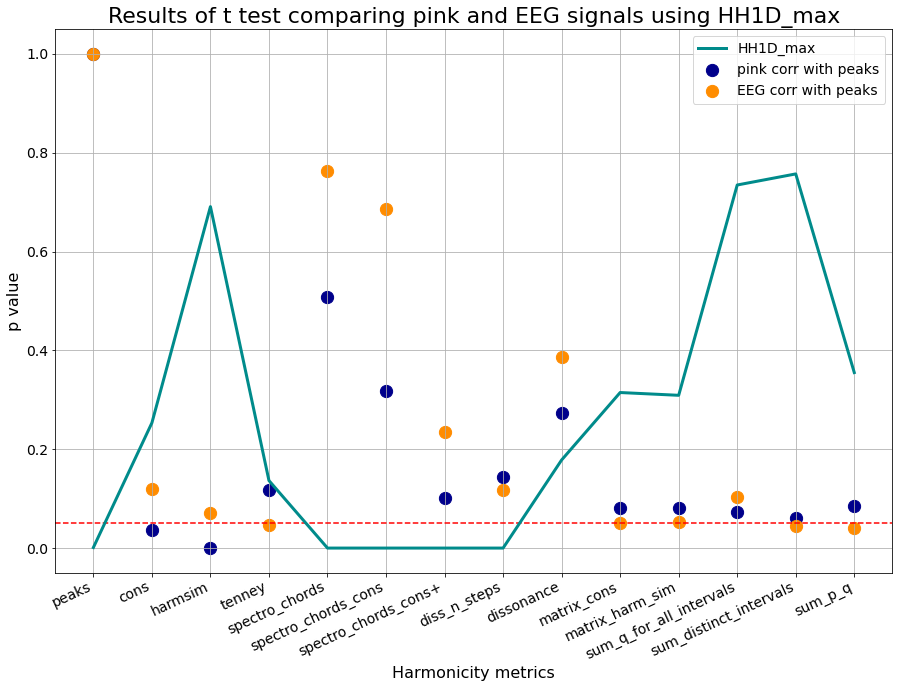

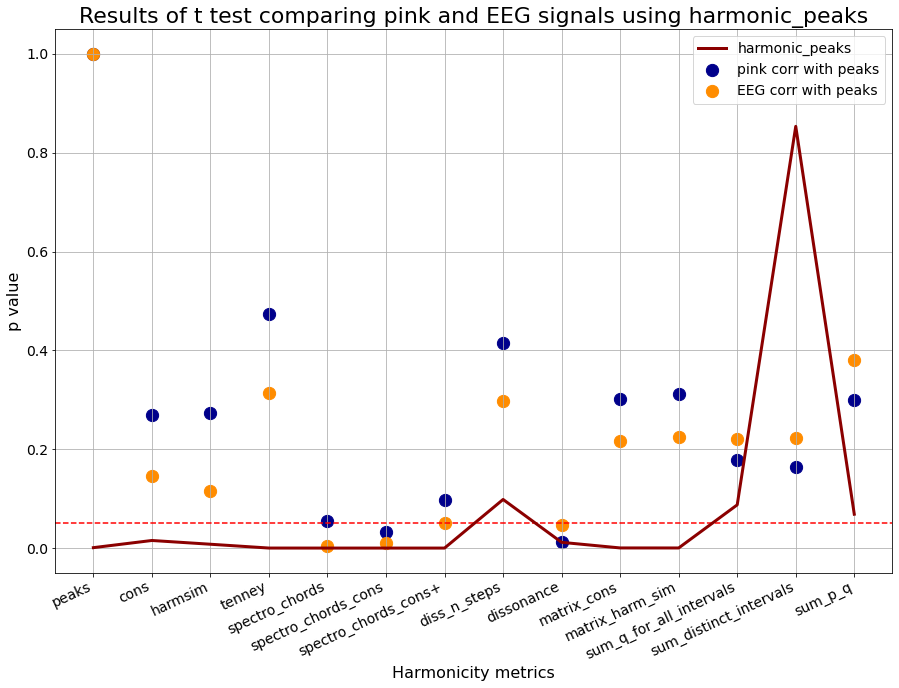

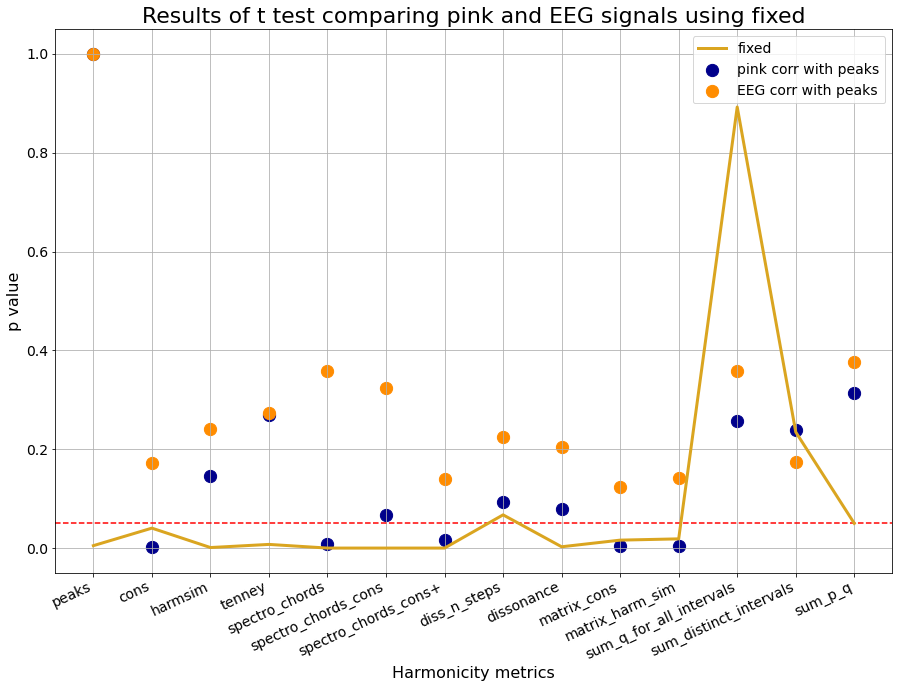

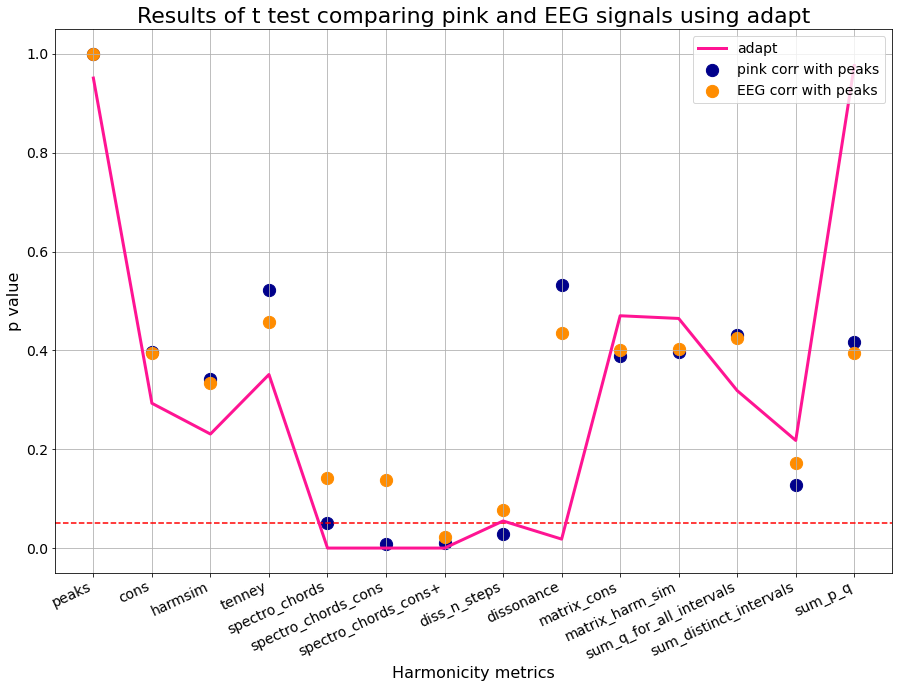

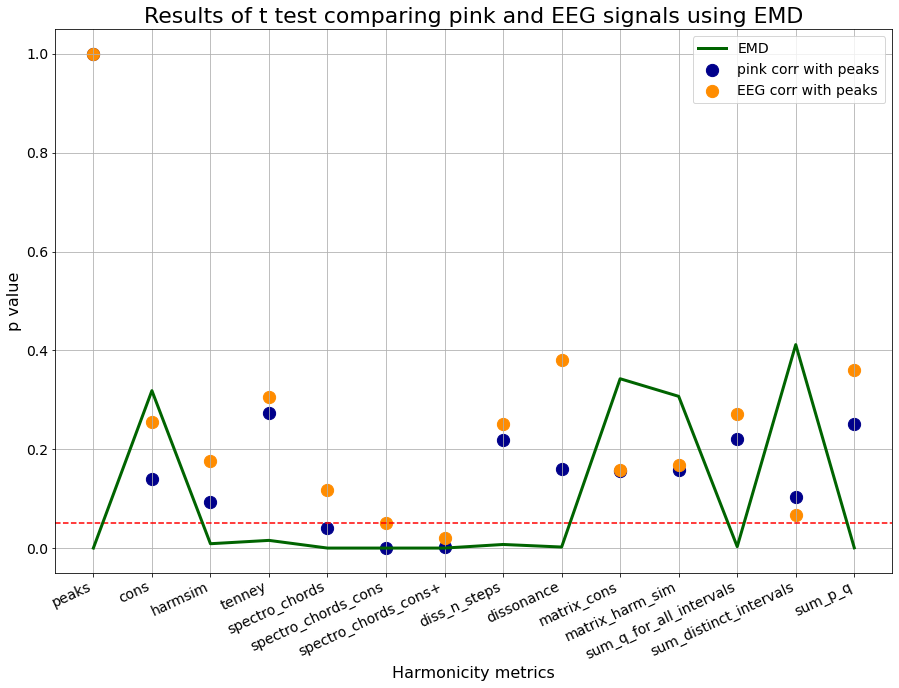

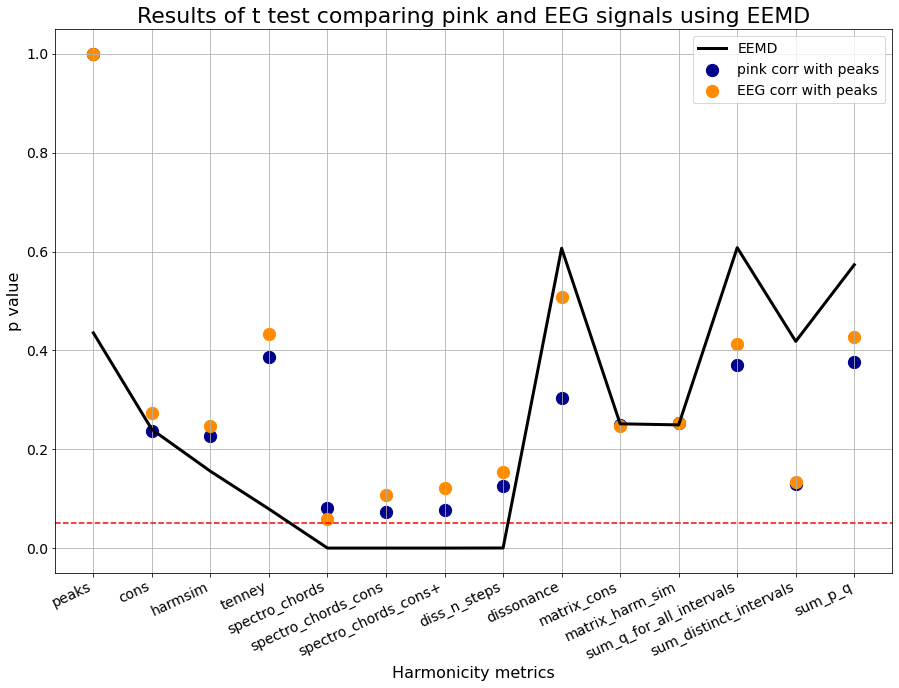

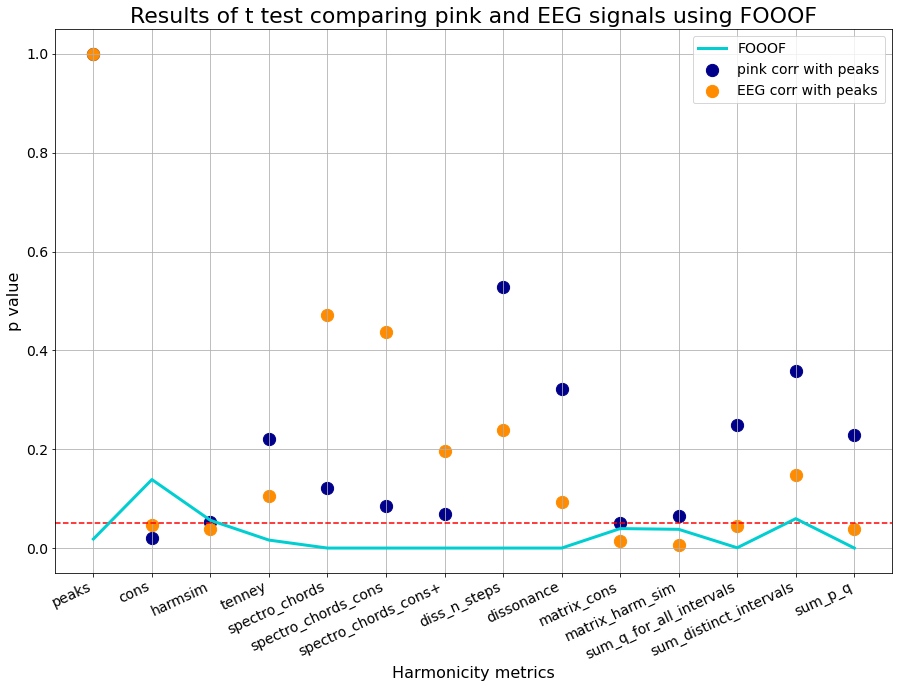

In [482]:
ttest_all_EEG_pink = ttest_all_metrics_all_functions(pink_metrics, EEG_metrics, peaks_functions)
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all_EEG_pink, function, labels = ['pink', 'EEG'], 
                           peaks_corr1=peaks_corr_pink, peaks_corr2=peaks_corr_EEG, color=color, save=True)

In [514]:
ttest_all_EEG_pink

,EEMD
peaks,"[0.6391427197600401, -0.4694725777084404]"
cons,"[0.17184190313230485, 1.3702535365434103]"
harmsim,"[0.12025847756520425, 1.5590336293733205]"
tenney,"[0.06326481361644666, -1.8656603235706084]"
spectro_chords,"[1.1247701789458849e-265, -180.00672235829728]"
spectro_chords_cons,"[1.9874969429047915e-150, -60.220079858634335]"
spectro_chords_cons+,"[7.893098580722939e-101, -36.05920368577337]"
diss_n_steps,"[0.0041185245357659205, -2.895756709800971]"
dissonance,"[0.8105614551458535, 0.23995642993753039]"
matrix_cons,"[0.20391066012658488, 1.273832070881403]"


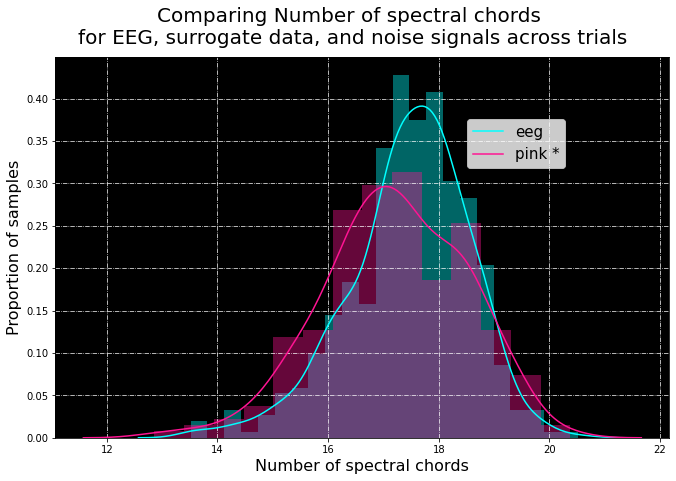

In [513]:
test_graph = [EEG_metrics[6]['tenney'], pink_metrics[6]['tenney']]
graph_dist(test_graph, metric = 'n_spectro_chords', ref = test_graph[0], dimensions = [0], labs = ['eeg', 'pink'], 
           savefolder = '\\', subject = '0', tag = '0', adapt = 'False', 
           peaks_function = 'HH1D_max', colors = None, display = True, save = False, title=None)

## Which harmonicity metrics best distinguish between EEG signal and surrogate data using phase randomization ?

In [526]:
phase_data = surrogate_signal_matrices(EEG_data[0:250, 2000:7000], surr_type = 'phase', low_cut = 0.5, high_cut = 150, sf = 1000)

In [527]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['HH1D_max', 'harmonic_peaks', 'fixed', 'adapt', 'EMD', 'EEMD', 'FOOOF']
peaks_corr_phase, phase_metrics = compare_corr_metrics_peaks(phase_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

peaks_corr_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data[0:250, 2000:7000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

phase_metrics = np.array(phase_metrics)
EEG_metrics = np.array(EEG_metrics)

HH1D_max
harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF
HH1D_max
harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF


In [528]:
np.save('peaks_corr_EEG_0.5_w-phase.npy', peaks_corr_EEG)
np.save('peaks_corr_phase_0.5.npy', peaks_corr_phase)

np.save('EEG_metrics_0.5_w-phase.npy', EEG_metrics)
np.save('phase_metrics_0.5.npy', phase_metrics)

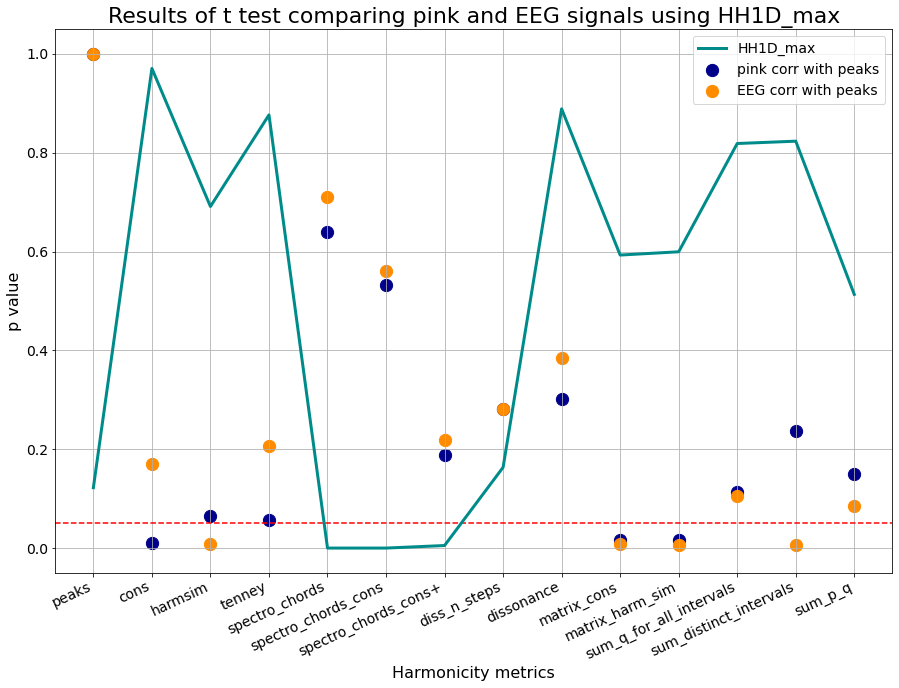

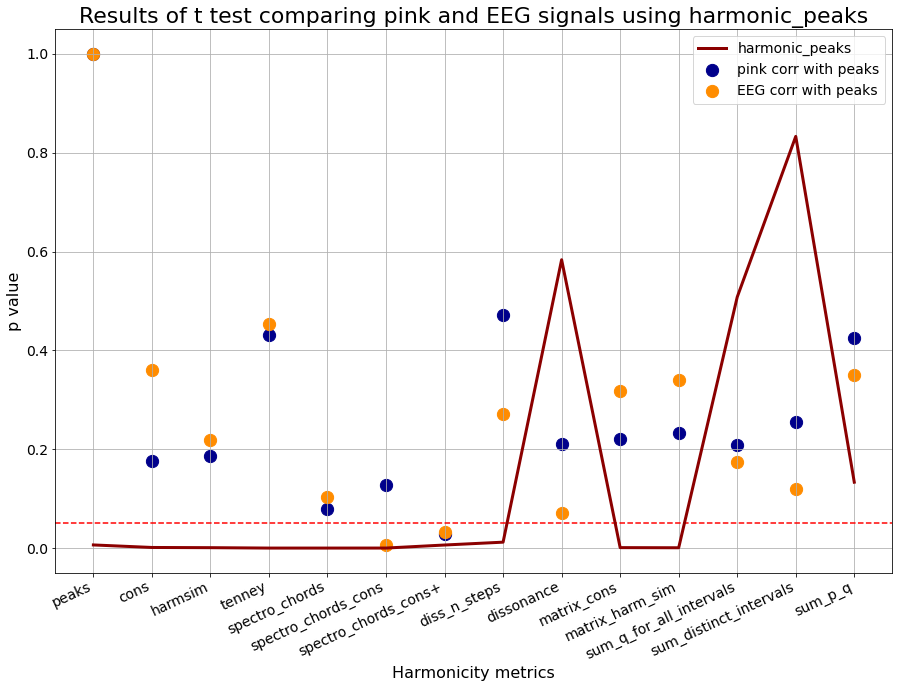

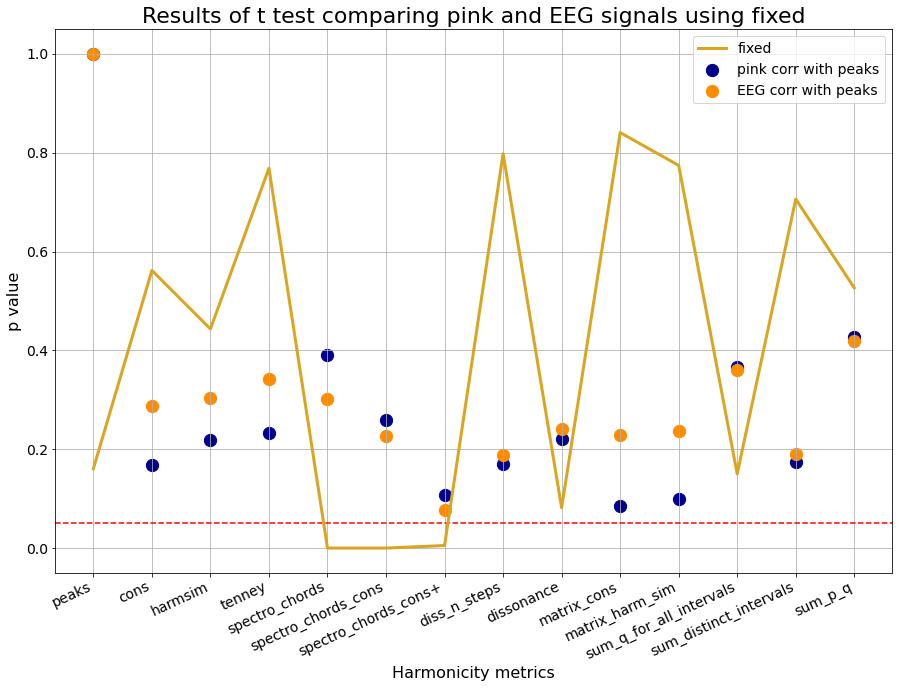

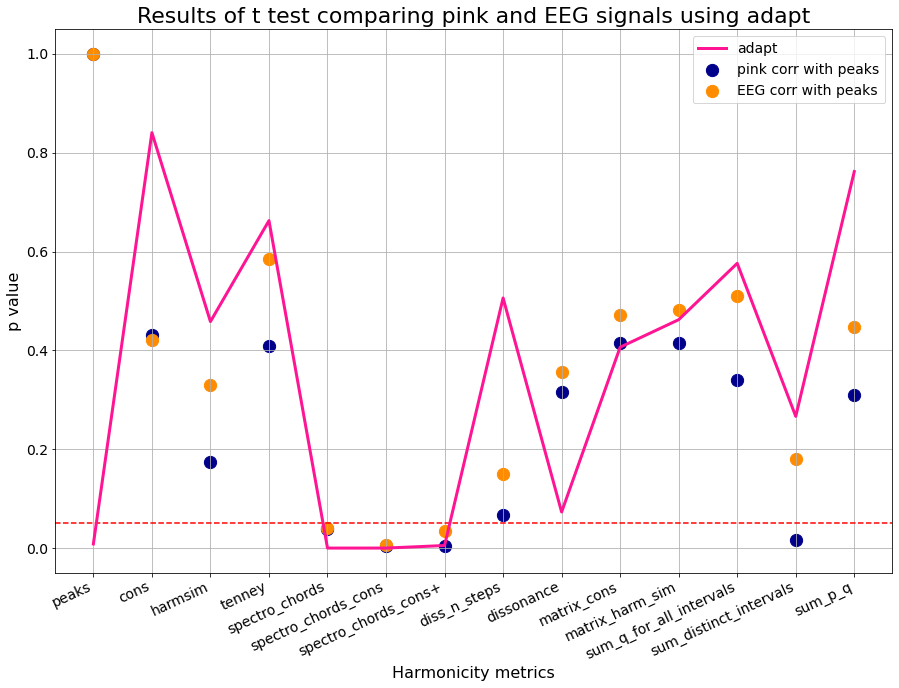

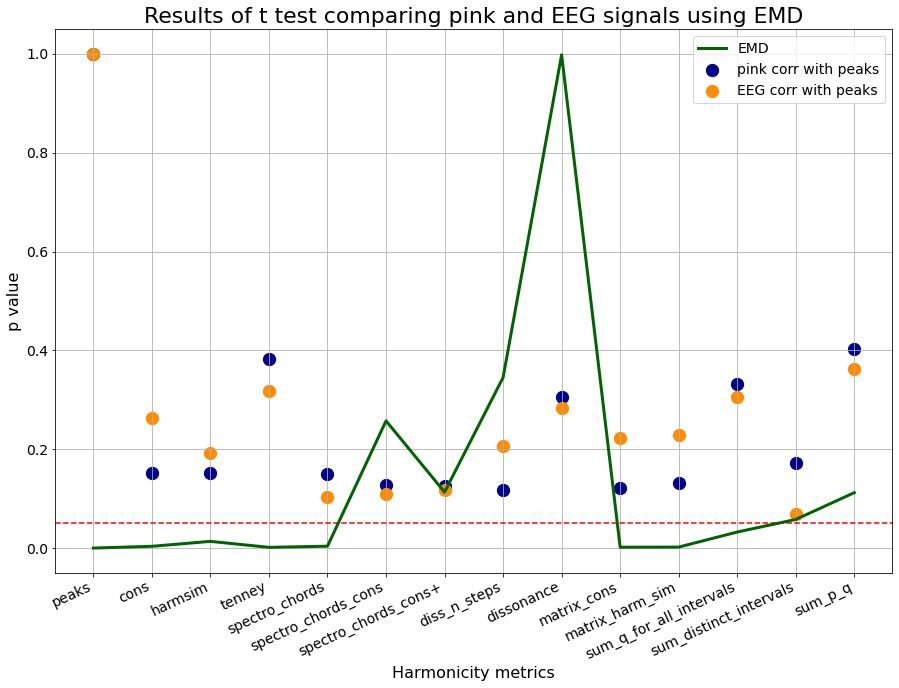

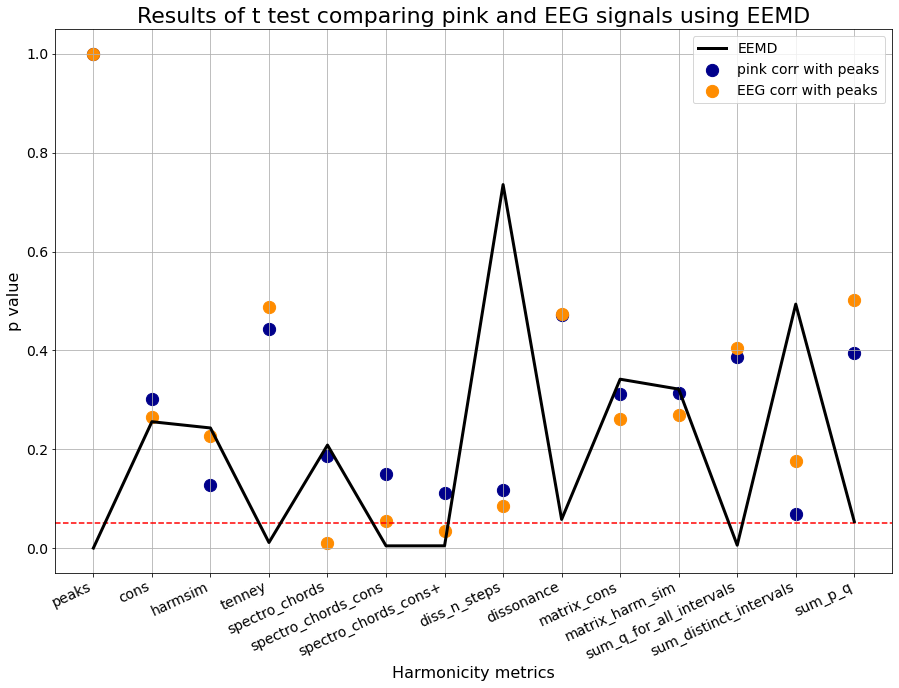

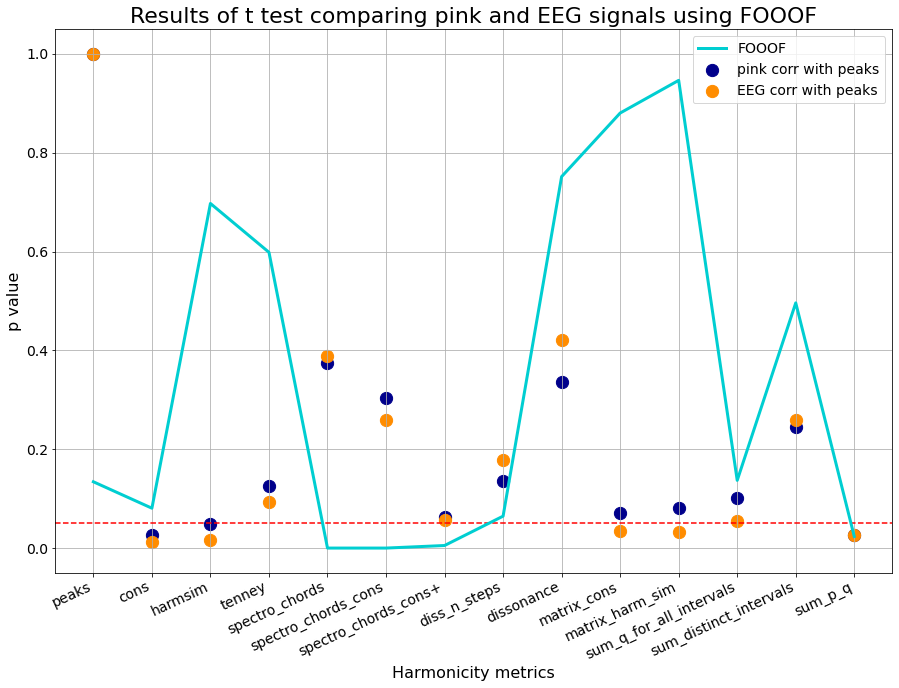

In [530]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all_EEG_phase = ttest_all_metrics_all_functions(phase_metrics, EEG_metrics, peaks_functions)
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all_EEG_phase, function, labels = ['pink', 'EEG'], 
                           peaks_corr1=peaks_corr_phase, peaks_corr2=peaks_corr_EEG, color=color, save=True)

In [6]:
AAFT_data = surrogate_signal_matrices(EEG_data[0:250, 2000:7000], surr_type = 'phase', low_cut = 0.5, high_cut = 150, sf = 1000)

In [ ]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['HH1D_max', 'harmonic_peaks', 'fixed', 'adapt', 'EMD', 'EEMD', 'FOOOF']
peaks_corr_phase, phase_metrics = compare_corr_metrics_peaks(AAFT_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

phase_metrics = np.array(phase_metrics)

np.save('peaks_corr_AAFT_0.5.npy', peaks_corr_phase)
np.save('AAFT_metrics_0.5.npy', phase_metrics)

HH1D_max


In [ ]:
peaks_corr_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data[0:250, 2000:7000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

EEG_metrics = np.array(EEG_metrics)

In [ ]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all_EEG_AAFT = ttest_all_metrics_all_functions(AAFT_metrics, EEG_metrics, peaks_functions)
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all_EEG_AAFT, function, labels = ['pink', 'EEG'], 
                           peaks_corr1=peaks_corr_AAFT, peaks_corr2=peaks_corr_EEG, color=color, save=True)

In [4]:
def plot_ttest_all_metrics(ttest_all, peaks_function, labels = ['EEG', 'ECG'], peaks_corr1=None, peaks_corr2=None,
                           color='darkred', save=False):

    fig, ax = plt.subplots(figsize=(15,10))
    plt.setp(ax.get_xticklabels(), rotation=25, horizontalalignment='right')
    plt.title('Results of t test comparing '+labels[0]+' and '+labels[1]+' signals using '+peaks_function, fontsize=22)
    plt.xlabel('Harmonicity metrics', fontsize=16)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.ylabel('p value',  fontsize=16)
    plt.axhline(y=0.05, color='r', linestyle='--')

    plt.plot(ttest_all[peaks_function], color=color, label=peaks_function, linewidth=3)
    #if peaks_corr1 != None and peaks_corr2 != None:
    x_position1 = list(range(len(peaks_corr1[peaks_function])))
    #x_position1 = [x+1 for x in x_position1]
    x_position2 = list(range(len(peaks_corr2[peaks_function])))
    #x_position2 = [x+1 for x in x_position2]
    plt.scatter(x_position1, peaks_corr1[peaks_function],
                color='darkblue', label=labels[0]+' corr with peaks', s=150)
    plt.scatter(x_position2, peaks_corr2[peaks_function],
                color='darkorange', label=labels[1]+' corr with peaks', s=150)
    plt.grid()
    plt.legend(loc='upper right', fontsize=14)
    plt.show
    if save==True:
        plt.savefig('ttest_'+labels[0]+'_'+labels[1]+'_'+peaks_function+'.jpg', dpi=300, facecolor='w')
def ttest_all_metrics(data1, data2, function_name):
    list_metrics = list(data1.columns)
    ttest_all = pd.DataFrame()
    metrics_ = []
    for metric in list_metrics:
        a = data1[metric]
        b = data2[metric]
        a = [x for x in a if str(x) != 'nan']
        b = [x for x in b if str(x) != 'nan']
        if len(a) > len(b):
            a = a[0:len(b)]
        if len(b) > len(a):
            b = b[0:len(a)]
        t, p = stats.ttest_rel(a, b)
        metrics_.append(p)
    ttest_all[function_name]=metrics_
    ttest_all = ttest_all.set_axis(list_metrics, axis='index')
    return ttest_all


In [5]:
def ttest_all_metrics_all_functions(data1, data2, peaks_functions):
    list_metrics = list(data1[1].columns)
    ttest_all = pd.DataFrame()
    for function, function_name in zip(range(len(peaks_functions)), peaks_functions):
        metrics_ = []
        for metric in list_metrics:
            a = data1[function][metric]
            b = data2[function][metric]
            a = [x for x in a if str(x) != 'nan']
            b = [x for x in b if str(x) != 'nan']
            if len(a) > len(b):
                a = a[0:len(b)]
            if len(b) > len(a):
                b = b[0:len(a)]
            t, p = stats.ttest_rel(a, b)
            metrics_.append(p)
        ttest_all[function_name]=metrics_
    ttest_all = ttest_all.set_axis(list_metrics, axis='index')
    return ttest_all